# Read Data Sample

In [1]:
import pandas as pd
import numpy as np
import os
from collections import namedtuple
pd.set_option("display.max_rows",100)
%matplotlib inline

In [2]:
%%bash
rm dataset/scores/tf_dense_only_nsl_kdd_scores_all-.pkl

In [3]:
class dataset:
    kdd_train_2labels = pd.read_pickle("dataset/kdd_train__2labels.pkl")
    kdd_test_2labels = pd.read_pickle("dataset/kdd_test_2labels.pkl")
    kdd_test__2labels = pd.read_pickle("dataset/kdd_test__2labels.pkl")

    kdd_train_5labels = pd.read_pickle("dataset/kdd_train_5labels.pkl")
    kdd_test_5labels = pd.read_pickle("dataset/kdd_test_5labels.pkl")
    

In [4]:
dataset.kdd_train_2labels.shape

(25192, 124)

In [5]:
dataset.kdd_test_2labels.shape

(22544, 124)

In [6]:
from sklearn import model_selection as ms
from sklearn import preprocessing as pp

class preprocess:
    
    output_columns_2labels = ['is_Normal','is_Attack']
    
    x_input = dataset.kdd_train_2labels.drop(output_columns_2labels, axis = 1)
    y_output = dataset.kdd_train_2labels.loc[:,output_columns_2labels]

    x_test_input = dataset.kdd_test_2labels.drop(output_columns_2labels, axis = 1)
    y_test = dataset.kdd_test_2labels.loc[:,output_columns_2labels]
    
    x_test__input = dataset.kdd_test__2labels.drop(output_columns_2labels, axis = 1)
    y_test_ = dataset.kdd_test__2labels.loc[:,output_columns_2labels]

    ss = pp.StandardScaler()

    x_train = ss.fit_transform(x_input)
    x_test = ss.transform(x_test_input)
    x_test_ = ss.transform(x_test__input)

    y_train = y_output.values
    y_test = y_test.values
    y_test_ = y_test_.values

preprocess.x_train.shape

(25192, 122)

In [7]:
import tensorflow as tf


In [8]:
class network(object):
    
    input_dim = 122
    classes = 2
    hidden_encoder_dim = 122
    hidden_layers = 1
    latent_dim = 18

    def __init__(self, classes, hidden_layers, num_of_features):
        self.classes = classes
        self.hidden_layers = hidden_layers
        self.latent_dim = num_of_features
            
    def build_layers(self):
        tf.reset_default_graph()
        #learning_rate = tf.Variable(initial_value=0.001)

        input_dim = self.input_dim
        classes = self.classes
        hidden_encoder_dim = self.hidden_encoder_dim
        hidden_layers = self.hidden_layers
        latent_dim = self.latent_dim
        
        with tf.variable_scope("Input"):
            self.x = tf.placeholder("float", shape=[None, input_dim])
            self.y_ = tf.placeholder("float", shape=[None, classes])
            self.keep_prob = tf.placeholder("float")
            self.lr = tf.placeholder("float")
        
        with tf.variable_scope("Layer_Encoder"):

            hidden_encoder = tf.layers.dense(self.x, hidden_encoder_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
            hidden_encoder = tf.nn.dropout(hidden_encoder, self.keep_prob)
            for h in range(hidden_layers - 1):
                hidden_encoder = tf.layers.dense(hidden_encoder, latent_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
                hidden_encoder = tf.nn.dropout(hidden_encoder, self.keep_prob)
            
            #hidden_encoder = tf.layers.dense(self.x, latent_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
            #hidden_encoder = tf.nn.dropout(hidden_encoder, self.keep_prob)
            
        with tf.variable_scope("Layer_Dense_Softmax"):
            self.y = tf.layers.dense(hidden_encoder, classes, activation=tf.nn.softmax)
            
        with tf.variable_scope("Loss"):
            
            loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = self.y_, logits = self.y))

            #loss = tf.clip_by_value(loss, -1e-1, 1e-1)
            #loss = tf.where(tf.is_nan(loss), 1e-1, loss)
            #loss = tf.where(tf.equal(loss, -1e-1), tf.random_normal(loss.shape), loss)
            #loss = tf.where(tf.equal(loss, 1e-1), tf.random_normal(loss.shape), loss)
            
            self.regularized_loss = loss
            correct_prediction = tf.equal(tf.argmax(self.y_, 1), tf.argmax(self.y, 1))
            self.tf_accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name = "Accuracy")

        with tf.variable_scope("Optimizer"):
            learning_rate=self.lr
            optimizer = tf.train.AdamOptimizer(learning_rate)
            gradients, variables = zip(*optimizer.compute_gradients(self.regularized_loss))
            gradients = [
                None if gradient is None else tf.clip_by_value(gradient, -1, 1)
                for gradient in gradients]
            self.train_op = optimizer.apply_gradients(zip(gradients, variables))
            #self.train_op = optimizer.minimize(self.regularized_loss)
            
        # add op for merging summary
        #self.summary_op = tf.summary.merge_all()
        self.pred = tf.argmax(self.y, axis = 1)
        self.actual = tf.argmax(self.y_, axis = 1)

        # add Saver ops
        self.saver = tf.train.Saver()
        

In [9]:
import collections
import time
import sklearn.metrics as me 

class Train:    
    
    result = namedtuple("score", ['epoch', 'no_of_features','hidden_layers','train_score', 'test_score', 'f1_score', 'test_score_20', 'f1_score_20', 'time_taken'])

    predictions = {}
    predictions_ = {}

    results = []
    
    best_acc = 0
    best_acc_global = 0
    
    def train(epochs, net, h,f, lrs):
        batch_iterations = 200
        train_loss = None
        Train.best_acc = 0
        os.makedirs("dataset/tf_dense_only_nsl_kdd-/hidden layers_{}_features count_{}".format(epochs,h,f),
                    exist_ok = True)
        with tf.Session() as sess:
            #summary_writer_train = tf.summary.FileWriter('./logs/kdd/VAE/training', graph=sess.graph)
            #summary_writer_valid = tf.summary.FileWriter('./logs/kdd/VAE/validation')

            sess.run(tf.global_variables_initializer())
            start_time = time.perf_counter()
            for c, lr in enumerate(lrs):
                for epoch in range(1, (epochs+1)):
                    x_train, x_valid, y_train, y_valid, = ms.train_test_split(preprocess.x_train, 
                                                                              preprocess.y_train, 
                                                                              test_size=0.1)
                    batch_indices = np.array_split(np.arange(x_train.shape[0]), 
                                               batch_iterations)

                    for i in batch_indices:

                        def train_batch():
                            nonlocal train_loss
                            _, train_loss = sess.run([net.train_op, 
                                                               net.regularized_loss, 
                                                               ], #net.summary_op
                                                              feed_dict={net.x: x_train[i,:], 
                                                                         net.y_: y_train[i,:], 
                                                                         net.keep_prob:0.5, net.lr:lr})

                        train_batch()
                        #summary_writer_train.add_summary(summary_str, epoch)
                        while((train_loss > 1e4 or np.isnan(train_loss)) and epoch > 1):
                            print("Step {} | Training Loss: {:.6f}".format(epoch, train_loss))
                            net.saver.restore(sess, 
                                              tf.train.latest_checkpoint('dataset/tf_dense_only_nsl_kdd-/hidden_layers_{}_features_count_{}'
                                                                         .format(epochs,h,f)))
                            train_batch()


                    valid_accuracy = sess.run(net.tf_accuracy, #net.summary_op 
                                                          feed_dict={net.x: x_valid, 
                                                                     net.y_: y_valid, 
                                                                     net.keep_prob:1, net.lr:lr})
                    #summary_writer_valid.add_summary(summary_str, epoch)


                    accuracy, pred_value, actual_value, y_pred = sess.run([net.tf_accuracy, 
                                                                   net.pred, 
                                                                   net.actual, net.y], 
                                                                  feed_dict={net.x: preprocess.x_test, 
                                                                             net.y_: preprocess.y_test, 
                                                                             net.keep_prob:1, net.lr:lr})
                    f1_score = me.f1_score(actual_value, pred_value)
                    accuracy_, pred_value_, actual_value_, y_pred_ = sess.run([net.tf_accuracy, 
                                                                   net.pred, 
                                                                   net.actual, net.y], 
                                                                  feed_dict={net.x: preprocess.x_test_, 
                                                                             net.y_: preprocess.y_test_, 
                                                                             net.keep_prob:1, net.lr:lr})
                    f1_score_ = me.f1_score(actual_value_, pred_value_)
                    
                    print("Step {} | Training Loss: {:.6f} | Validation Accuracy: {:.6f}".format(epoch, train_loss, valid_accuracy))
                    print("Accuracy on Test data: {}, {}".format(accuracy, accuracy_))

                    if accuracy > Train.best_acc_global:
                        Train.best_acc_global = accuracy
                        Train.pred_value = pred_value
                        Train.actual_value = actual_value
                        Train.pred_value_ = pred_value_
                        Train.actual_value_ = actual_value_
                        Train.best_parameters = "Hidden Layers:{}, Features Count:{}".format(h, f)

                    if accuracy > Train.best_acc:
                        Train.best_acc = accuracy

                        if not (np.isnan(train_loss)):
                            net.saver.save(sess, 
                                       "dataset/tf_dense_only_nsl_kdd-/hidden_layers_{}_features_count_{}".format(h,f),
                                        global_step = epochs)
                        curr_pred = pd.DataFrame({"Attack_prob":y_pred[:,-2], "Normal_prob":y_pred[:, -1], "Prediction":pred_value, "Actual":actual_value})
                        curr_pred_ = pd.DataFrame({"Attack_prob":y_pred_[:,-2], "Normal_prob":y_pred_[:, -1], "Prediction":pred_value_, "Actual": actual_value_})
                        
                        Train.predictions.update({"{}_{}_{}".format((epoch+1)*(c+1),f,h):(curr_pred, 
                                                   Train.result((epoch+1)*(c+1), f, h, valid_accuracy, accuracy, f1_score, accuracy_, f1_score_, time.perf_counter() - start_time))})
                        Train.predictions_.update({"{}_{}_{}".format((epoch+1)*(c+1),f,h):(curr_pred_, 
                                                   Train.result((epoch+1)*(c+1), f, h, valid_accuracy, accuracy, f1_score, accuracy_, f1_score_, time.perf_counter() - start_time))})

                        #Train.results.append(Train.result(epochs, f, h,valid_accuracy, accuracy))


In [10]:
import itertools

df_results = []
past_scores = []

class Hyperparameters:
#    features_arr = [2, 4, 8, 16, 32, 64, 128, 256]
#    hidden_layers_arr = [2, 4, 6, 10]

    def start_training():
        print("********************************** Training ******************************")

        global df_results
        global past_scores
        Train.predictions = {}
        Train.predictions_ = {}

        Train.results = []
    
        
        features_arr = [1, 12, 24, 48, 122]
        hidden_layers_arr = [1, 3]

        epochs = [5]
        lrs = [1e-5, 1e-6]
        print("********************************** Entering Loop ******************************")

        for e, h, f in itertools.product(epochs, hidden_layers_arr, features_arr):
            print("Current Layer Attributes - epochs:{} hidden layers:{} features count:{}".format(e,h,f))
            n = network(2,h,f)
            n.build_layers()
            Train.train(e, n, h,f, lrs)
            
        dict1 = {}
        dict1_ = {}
        dict2 = []

        for k, (v1, v2) in Train.predictions.items():
            dict1.update({k: v1})
            dict2.append(v2)

        for k, (v1_, v2) in Train.predictions_.items():
            dict1_.update({k: v1_})

        Train.predictions = dict1
        Train.predictions_ = dict1_
        
        Train.results = dict2
        df_results = pd.DataFrame(Train.results)

        #temp = df_results.set_index(['no_of_features', 'hidden_layers'])

        if not os.path.isfile('dataset/scores/tf_dense_only_nsl_kdd_scores_all-.pkl'):
            past_scores = df_results
        else:
            past_scores = pd.read_pickle("dataset/scores/tf_dense_only_nsl_kdd_scores_all-.pkl")
            past_scores = past_scores.append(df_results, ignore_index=True)
        past_scores.to_pickle("dataset/scores/tf_dense_only_nsl_kdd_scores_all-.pkl")

In [11]:
#%%timeit -r 10
#capture
Hyperparameters.start_training()

********************************** Training ******************************
********************************** Entering Loop ******************************
Current Layer Attributes - epochs:5 hidden layers:1 features count:1
Step 1 | Training Loss: 0.804066 | Validation Accuracy: 0.543254
Accuracy on Test data: 0.4374556541442871, 0.19578059017658234
Step 2 | Training Loss: 0.709505 | Validation Accuracy: 0.588889
Accuracy on Test data: 0.4477466344833374, 0.21392405033111572
Step 3 | Training Loss: 0.660634 | Validation Accuracy: 0.601190
Accuracy on Test data: 0.4582594037055969, 0.23265822231769562
Step 4 | Training Loss: 0.602664 | Validation Accuracy: 0.730952
Accuracy on Test data: 0.507762610912323, 0.24793249368667603
Step 5 | Training Loss: 0.588001 | Validation Accuracy: 0.759524
Accuracy on Test data: 0.5309173464775085, 0.2886075973510742
Step 1 | Training Loss: 0.599571 | Validation Accuracy: 0.757143
Accuracy on Test data: 0.5338005423545837, 0.29375526309013367
Step 2 | T

/home/ritesh_malaiya/anaconda3/envs/p3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Step 1 | Training Loss: 0.693112 | Validation Accuracy: 0.551190
Accuracy on Test data: 0.43075764179229736, 0.18160337209701538
Step 2 | Training Loss: 0.693037 | Validation Accuracy: 0.546429
Accuracy on Test data: 0.43075764179229736, 0.18160337209701538
Step 3 | Training Loss: 0.693286 | Validation Accuracy: 0.543254
Accuracy on Test data: 0.43075764179229736, 0.18160337209701538
Step 4 | Training Loss: 0.693048 | Validation Accuracy: 0.530159
Accuracy on Test data: 0.43075764179229736, 0.18160337209701538
Step 5 | Training Loss: 0.693126 | Validation Accuracy: 0.535714
Accuracy on Test data: 0.43075764179229736, 0.18160337209701538
Step 1 | Training Loss: 0.692970 | Validation Accuracy: 0.531746
Accuracy on Test data: 0.43075764179229736, 0.18160337209701538
Step 2 | Training Loss: 0.692914 | Validation Accuracy: 0.547619
Accuracy on Test data: 0.43075764179229736, 0.18160337209701538
Step 3 | Training Loss: 0.692909 | Validation Accuracy: 0.523413
Accuracy on Test data: 0.4307576

In [12]:
#g = df_results.groupby(by=['no_of_features'])
#idx = g['test_score'].transform(max) == df_results['test_score']
#df_results[idx].sort_values(by = 'test_score', ascending = False)

In [13]:
#g = df_results.groupby(by=['no_of_features'])
#idx = g['test_score_20'].transform(max) == df_results['test_score_20']
#df_results[idx].sort_values(by = 'test_score_20', ascending = False)

In [14]:
#df_results.sort_values(by = 'test_score', ascending = False)

In [15]:
#Train.predictions_

In [16]:
pd.Panel(Train.predictions).to_pickle("dataset/tf_dense_only_nsl_kdd_predictions-.pkl")
pd.Panel(Train.predictions_).to_pickle("dataset/tf_dense_only_nsl_kdd_predictions-__.pkl")

df_results.to_pickle("dataset/tf_dense_only_nsl_kdd_scores-.pkl")


In [17]:
import numpy as np
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    np.set_printoptions(precision=4)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        #print('Confusion matrix, without normalization')
        pass
    
    #print(cm)

    label = [["\n True Negative", "\n False Positive \n Type II Error"],
             ["\n False Negative \n Type I Error", "\n True Positive"]
            ]
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        
        plt.text(j, i, "{} {}".format(cm[i, j].round(4), label[i][j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot(actual_value, pred_value):
    from sklearn.metrics import confusion_matrix

    cm_2labels = confusion_matrix(y_pred = pred_value, y_true = actual_value)
    plt.figure(figsize=[6,6])
    plot_confusion_matrix(cm_2labels, ['Normal', 'Attack'], normalize = False)


In [18]:
#plot(actual_value = Train.actual_value, pred_value = Train.pred_value)

In [19]:
#plot(actual_value = Train.actual_value_, pred_value = Train.pred_value_)

In [20]:
past_scores = pd.read_pickle("dataset/scores/tf_dense_only_nsl_kdd_scores_all-.pkl")

In [21]:
past_scores.sort_values(by='f1_score',ascending=False)

,epoch,no_of_features,hidden_layers,train_score,test_score,f1_score,test_score_20,f1_score_20,time_taken
23,2,48,1,0.846825,0.856104,0.869488,0.750380,0.839570,0.642131
26,10,48,1,0.914286,0.857878,0.867734,0.741857,0.828982,4.327987
25,8,48,1,0.915476,0.857523,0.867393,0.741181,0.828516,3.768181
24,6,48,1,0.912302,0.857346,0.867195,0.740844,0.828234,3.158489
22,10,24,1,0.884127,0.845014,0.847968,0.711392,0.795185,5.346153
21,8,24,1,0.885317,0.844216,0.847078,0.710211,0.794199,4.741357
20,6,24,1,0.879762,0.843772,0.846576,0.709367,0.793476,4.194588
18,4,24,1,0.869841,0.842575,0.845299,0.707511,0.791957,3.586408
19,5,24,1,0.846429,0.834147,0.836632,0.696793,0.783385,2.446598
63,5,122,3,0.874603,0.827449,0.836445,0.682785,0.784028,3.972664


In [22]:
psg = past_scores.sort_values(by='test_score', ascending=False).groupby(by=['no_of_features', 'hidden_layers'])
psg.first().sort_values(by='test_score', ascending=False)

epoch  train_score  test_score  f1_score  \
no_of_features hidden_layers                                             
48             1                 10     0.914286    0.857878  0.867734   
24             1                 10     0.884127    0.845014  0.847968   
122            3                  5     0.874603    0.827449  0.836445   
               1                 12     0.884921    0.798793  0.788984   
12             1                 12     0.888095    0.731237  0.701277   
               3                 12     0.857540    0.729595  0.704365   
48             3                 12     0.887698    0.704045  0.655265   
24             3                 12     0.817460    0.685282  0.622265   
1              1                 12     0.776190    0.560326  0.377152   
               3                  2     0.551190    0.430758  0.000000   

                              test_score_20  f1_score_20  time_taken  
no_of_features hidden_layers                                          
48             1                   0.741857     0.828982    4.327987  
24             1                   0.711392     0.795185    5.346153  
122            3                   0.682785     0.784028    3.972664  
               1                   0.626751     0.710366    5.995009  
12             1                   0.503629     0.579437    5.775745  
               3                   0.502110     0.587355    8.040761  
48             3                   0.448354     0.504960    8.769443  
24             3                   0.419409     0.456298    8.399888  
1              1                   0.315781     0.288022    5.756575  
               3                   0.181603     0.000000    0.857066

In [23]:
psg.mean().sort_values(by='test_score', ascending=False)

epoch  train_score  test_score  f1_score  \
no_of_features hidden_layers                                                
48             1              6.500000     0.897222    0.857213  0.867953   
122            3              3.500000     0.832044    0.799148  0.811015   
24             1              5.428571     0.744218    0.761888  0.781667   
122            1              6.250000     0.780754    0.724966  0.696372   
12             3              6.250000     0.825794    0.708686  0.675391   
               1              6.250000     0.829812    0.700591  0.662312   
48             3              6.250000     0.823562    0.652286  0.551390   
24             3              6.250000     0.723065    0.583293  0.477953   
1              1              6.250000     0.711806    0.513529  0.250800   
               3              2.000000     0.551190    0.430758  0.000000   

                              test_score_20  f1_score_20  time_taken  
no_of_features hidden_layers                                          
48             1                   0.743565     0.831326    2.974197  
122            3                   0.642405     0.756604    2.463423  
24             1                   0.685413     0.773989    3.160169  
122            1                   0.581814     0.664497    3.535491  
12             3                   0.477015     0.558293    4.720200  
               1                   0.468038     0.535805    3.422357  
48             3                   0.383924     0.396304    5.153420  
24             3                   0.357458     0.356645    4.937698  
1              1                   0.272679     0.199582    3.410016  
               3                   0.181603     0.000000    0.857066

In [24]:
Train.predictions = pd.read_pickle("dataset/tf_dense_only_nsl_kdd_predictions-.pkl")
Train.predictions_ = pd.read_pickle("dataset/tf_dense_only_nsl_kdd_predictions-__.pkl")

In [25]:
#epoch_nof_hidden
Train.predictions["12_12_3"]

,Actual,Attack_prob,Normal_prob,Prediction
0,1.0,0.315425,0.684575,1.0
1,1.0,0.313895,0.686105,1.0
2,0.0,0.518888,0.481112,0.0
3,1.0,0.492554,0.507446,1.0
4,1.0,0.407654,0.592345,1.0
5,0.0,0.766832,0.233168,0.0
6,0.0,0.624008,0.375992,0.0
7,1.0,0.676774,0.323226,0.0
8,0.0,0.746453,0.253547,0.0
9,1.0,0.533616,0.466384,0.0


In [26]:
Train.predictions_["12_12_3"]

,Actual,Attack_prob,Normal_prob,Prediction
0,1.0,0.543920,0.456081,0.0
1,1.0,0.526548,0.473452,0.0
2,1.0,0.496500,0.503500,1.0
3,0.0,0.579483,0.420517,0.0
4,1.0,0.319396,0.680604,1.0
5,1.0,0.705106,0.294894,0.0
6,1.0,0.197644,0.802356,1.0
7,1.0,0.515859,0.484141,0.0
8,0.0,0.575331,0.424669,0.0
9,0.0,0.472066,0.527934,1.0


In [27]:
df = Train.predictions["12_12_3"].dropna()
df_ = Train.predictions_["12_12_3"].dropna()

In [28]:
from sklearn import metrics as me
def get_score(y_true, y_pred):
    f1 = me.f1_score(y_true, y_pred)
    pre = me.precision_score(y_true, y_pred)
    rec = me.recall_score(y_true, y_pred)
    acc = me.accuracy_score(y_true, y_pred)
    return {"F1 Score":f1, "Precision":pre, "Recall":rec, "Accuracy":acc}


In [29]:
from sklearn import metrics as me

scores = get_score(df.loc[:,'Actual'].values.astype(int),
                df.loc[:,'Prediction'].values.astype(int))
scores.update({"Scenario":"Train+/Test+"})
score_df = pd.DataFrame(scores, index=[0])

scores = get_score(df_.loc[:,'Actual'].values.astype(int),
                df_.loc[:,'Prediction'].values.astype(int))
scores.update({"Scenario":"Train+/Test-"})

score_df = score_df.append(pd.DataFrame(scores, index=[1]))

score_df

,Accuracy,F1 Score,Precision,Recall,Scenario
0,0.729595,0.704365,0.932580,0.565885,Train+/Test+
1,0.502110,0.587355,0.912826,0.432976,Train+/Test-


In [30]:
df.groupby(by="Actual").Actual.count()

Actual
0.0     9711
1.0    12833
Name: Actual, dtype: int64

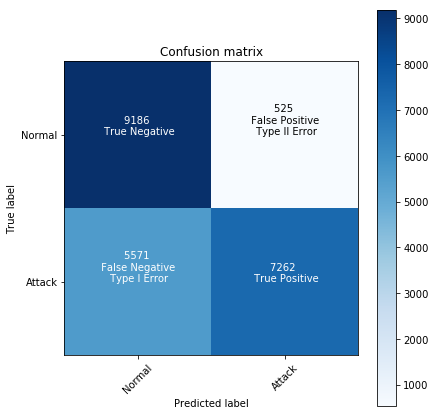

In [31]:
plot(actual_value = df.loc[:,'Actual'].values.astype(int),
     pred_value = df.loc[:,'Prediction'].values.astype(int))

In [32]:
df_.groupby(by="Actual").Actual.count()

Actual
0.0    2152
1.0    9698
Name: Actual, dtype: int64

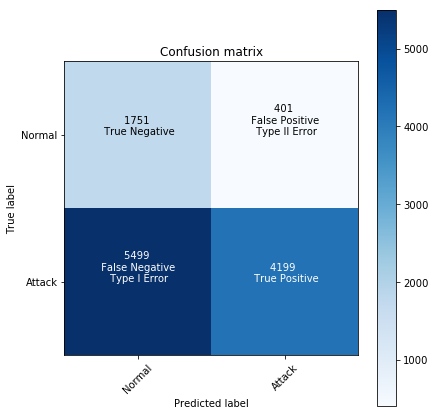

In [33]:
plot(actual_value = df_.loc[:,'Actual'].values.astype(int),
     pred_value = df_.loc[:,'Prediction'].values.astype(int))

In [34]:
from scipy import stats

def fn(x):
    #print(x)
    return stats.norm.interval(0.95, loc=x.f1_score.mean(), scale=x.f1_score.std())
psg.apply(fn)

no_of_features  hidden_layers
1               1                (-0.0106932141878, 0.512292833118)
                3                                        (nan, nan)
12              1                  (0.553520322795, 0.771103258353)
                3                  (0.589579017435, 0.761202912378)
24              1                   (0.553882891437, 1.00945197776)
                3                 (0.0413605111368, 0.914544769148)
48              1                   (0.86589960535, 0.870006020745)
                3                  (0.221270489485, 0.881508919623)
122             1                   (0.372951841349, 1.01979176516)
                3                  (0.750740841232, 0.871289928235)
dtype: object